# News Category Classification using Transformers

## 1. Load & Inspect the Dataset

### 1.1 Load the Dataset

In [1]:
import pandas as pd


DATA_PATH = "/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json"

df = pd.read_json(DATA_PATH, lines=True)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### 1.2 Remove Invalid Rows

In [4]:
df = df.dropna(subset=["category"])

df["headline"] = df["headline"].fillna("")
df["short_description"] = df["short_description"].fillna("")

print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (209527, 6)


### 1.3 Create Final Text Column and Sanity Check

In [5]:
df["text"] = df["headline"].str.strip() + " " + df["short_description"].str.strip()

df = df[df["text"].str.strip() != ""]

df[["category", "text"]].head()


print("Number of categories:", df["category"].nunique())

df["category"].unique()[:10]

df["text"].str.len().describe()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Number of categories: 42


count    209522.000000
mean        173.628144
std          78.549381
min           4.000000
25%         123.000000
50%         171.000000
75%         208.000000
max        1487.000000
Name: text, dtype: float64

## 2. Exploratory Data Analysis (EDA)

### 2.1 Category Distribution

In [6]:
import matplotlib.pyplot as plt

category_counts = df["category"].value_counts()

print(category_counts.head())
print(category_counts.tail())

category
POLITICS          35601
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: count, dtype: int64
category
ARTS & CULTURE    1339
COLLEGE           1144
LATINO VOICES     1130
CULTURE & ARTS    1074
EDUCATION         1014
Name: count, dtype: int64


### 2.2 Visualize Class Imbalance

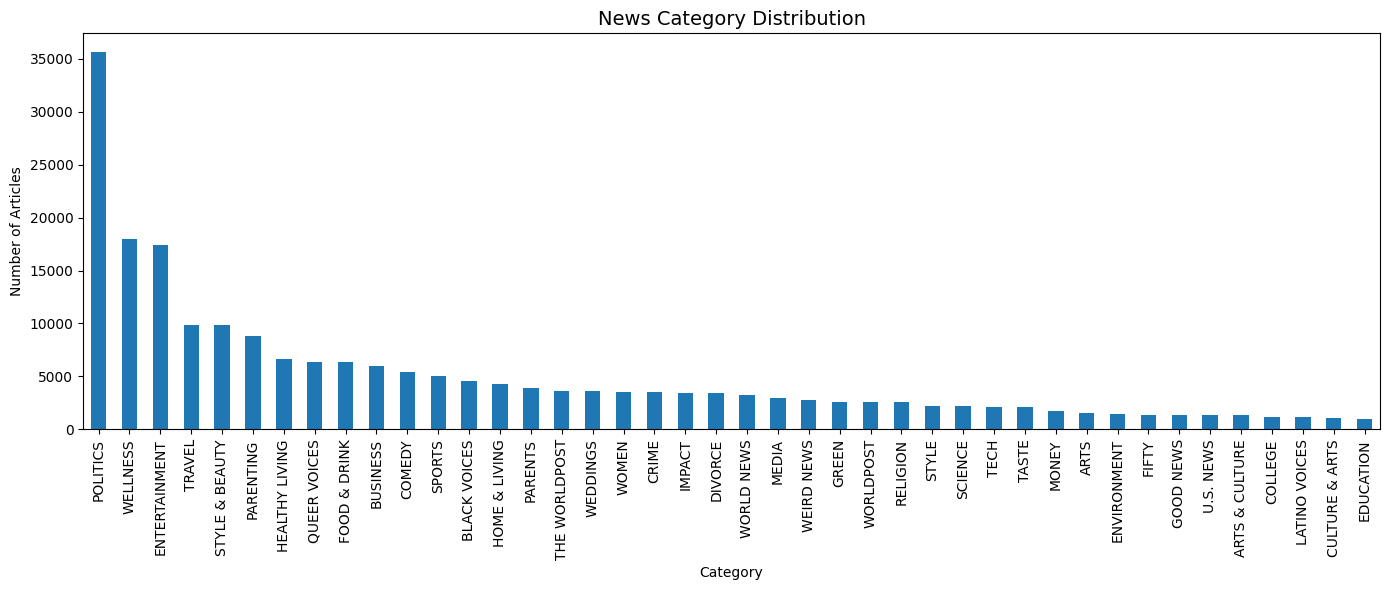

In [12]:
import matplotlib.pyplot as plt
import os

OUTPUT_DIR = "figures"
os.makedirs(OUTPUT_DIR, exist_ok=True)

category_counts = df["category"].value_counts()

plt.figure(figsize=(14, 6))
category_counts.plot(kind="bar")
plt.title("News Category Distribution", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plot_path = os.path.join(OUTPUT_DIR, "category_distribution.png")
plt.savefig(plot_path, dpi=300)
plt.close()

### 2.3 Identify Rare Categories

In [9]:
rare_categories = category_counts[category_counts < 1000]

print(f"Number of rare categories (<1000 samples): {len(rare_categories)}")

print("Top 5 categories cover:",
      category_counts.head(5).sum() / len(df) * 100, "% of data")

Number of rare categories (<1000 samples): 0
Top 5 categories cover: 43.2517826290318 % of data


## 3. Label Encoding and Stratified Train/Val/Test Split

### 3.1 Encode Category Labels

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df["label"] = label_encoder.fit_transform(df["category"])

num_labels = len(label_encoder.classes_)
print("Number of classes:", num_labels)

label_mapping = dict(zip(label_encoder.classes_, range(num_labels)))
label_mapping

Number of classes: 42


{'ARTS': 0,
 'ARTS & CULTURE': 1,
 'BLACK VOICES': 2,
 'BUSINESS': 3,
 'COLLEGE': 4,
 'COMEDY': 5,
 'CRIME': 6,
 'CULTURE & ARTS': 7,
 'DIVORCE': 8,
 'EDUCATION': 9,
 'ENTERTAINMENT': 10,
 'ENVIRONMENT': 11,
 'FIFTY': 12,
 'FOOD & DRINK': 13,
 'GOOD NEWS': 14,
 'GREEN': 15,
 'HEALTHY LIVING': 16,
 'HOME & LIVING': 17,
 'IMPACT': 18,
 'LATINO VOICES': 19,
 'MEDIA': 20,
 'MONEY': 21,
 'PARENTING': 22,
 'PARENTS': 23,
 'POLITICS': 24,
 'QUEER VOICES': 25,
 'RELIGION': 26,
 'SCIENCE': 27,
 'SPORTS': 28,
 'STYLE': 29,
 'STYLE & BEAUTY': 30,
 'TASTE': 31,
 'TECH': 32,
 'THE WORLDPOST': 33,
 'TRAVEL': 34,
 'U.S. NEWS': 35,
 'WEDDINGS': 36,
 'WEIRD NEWS': 37,
 'WELLNESS': 38,
 'WOMEN': 39,
 'WORLD NEWS': 40,
 'WORLDPOST': 41}

### 3.2 Save Label Mappings

In [14]:
import json
import os

os.makedirs("artifacts", exist_ok=True)

label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

with open("artifacts/label2id.json", "w") as f:
    json.dump(label2id, f, indent=2)

with open("artifacts/id2label.json", "w") as f:
    json.dump(id2label, f, indent=2)

print("Label mappings saved to artifacts/")

Label mappings saved to artifacts/


### 3.3 Prepare Features & Labels

In [15]:
X = df["text"].values
y = df["label"].values

### 3.4 Stratified Train / Validation / Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,      
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,      
    stratify=y_temp,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 146665
Validation size: 31428
Test size: 31429
